# Pipeline

Given the data from two different dates, check which products' prices went up or down.

### Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

### Loading and Wrangling

In [7]:
def load_csv(path: str) -> pd.DataFrame:
    """
    Load file and perform basic data wrangling.
    
    Parameters:
        path: String. CSV path.
        
    Returns:
        Pandas DataFrame
    """
    
    # Loads data from csv
    df = pd.read_csv(path)
    
    # Retrives input time
    date = df["Time"][0]
    
    # Turns prices into float
    df["Price"] = df["Price"].apply(lambda x: x.strip().rstrip(" €").replace(",", ".")).astype("float")
    print(path, df.shape)
    
    return df, date

In [8]:
def merge_it(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """
    Merge two dataframes together
    
    Parameters:
        df1: Pandas Dataframe.
        df2: Pandas Dataframe.
        
    Returns:
        Merged Pandas Dataframe.
    """
    
    merged = pd.merge(df1, df2, on="img_link", how="inner")
    merged = merged[['Category_x', 'Subcategory_x', 'Product_x', 'Specs_x', 'Price_x', 'Time_x', 'Price_y', 'Time_y']]
    merged.columns = ['Category', 'Subcategory', 'Product', 'Specs', 'Price_x', 'Time_x', 'Price_y', 'Time_y']
    print("Merged DataFrame:", merged.shape)
    return merged

In [9]:
def filter_it(df, level=None, elements=None):
    """
    Filter specific products given the level (Category or Subcategory) and elements to show up.
    
    Parameters:
        df: Pandas dataframe to filter.
        level: None or String. Filter columns, either "Category" or "Subcategory"
        elements: None, String or List of Strings. Filter dataframe by product or group of products. 
        This could be a string such as "Fruta", "Cerveza" etc, a list of strings, ["Fruta", "Cerveza"]
        or None (default). By setting it to None, nothing will be filtered. 
    """
    
    if level == None and elements == None:
        print("Original DataFrame:", df.shape)
        return df
    
    if isinstance(elements, str):
        filtered = df[df[level.capitalize()] == elements]
    elif isinstance(elements, list):
        filtered = df[df[level.capitalize()].isin(elements)]
    
    print("Filtered Dataframe:", filtered.shape)
    return filtered

In [10]:
def price_difference(original_df):
    """
    Add two columns, Price_diff and Price_single_pctg representing actual and percentual difference respectively.
    
    Parameters:
        original_df: Pandas DataFrame.
        
    Returns:
        Pandas Dataframe with two additional columns computed.
    """
    
    df = original_df.copy()
    df["Price_diff"] = df["Price_y"] - df["Price_x"]
    df["Price_single_pctg"] = round(100 * df["Price_diff"] / df["Price_x"], 3)
    
    return df

### Analysis

In [11]:
def min_max_products(df1, df2):
    """
    Return a dataframe with the most expensive and cheapest product.
    """
    
    # Fetching cheapest and most expensive products
    min1 = df1[df1["Price"] == df1["Price"].min()]
    max1 = df1[df1["Price"] == df1["Price"].max()]
    min2 = df2[df2["Price"] == df2["Price"].min()]
    max2 = df2[df2["Price"] == df2["Price"].max()]
    
    # Putting it all together
    full = pd.concat([min1, max1, min2, max2])
    full["Min/Max"] = ["Min", "Max", "Min", "Max"]
    full.drop(columns=["img_link", "Supermarket"], inplace=True)
    full.reset_index(drop=True, inplace=True)
    return full

In [12]:
def group_it(df, level):
    """
    Group DataFrame by level (Category, Subcategory or Product)
    
    Parameters:
        df: Pandas DataFrame coming from price_difference() function.
        level: Group level, it can be either "Category", "Subcategory" or "Product".
        
    Returns:
        Pandas DataFrame grouped by level. Columns: ['Price_x', 'Price_y', 'Price_diff', 'Price_pctg']
    """
    
    g = df.groupby(by=[level.capitalize()]).sum()[["Price_x", "Price_y", "Price_diff"]].round(2)
    g["Price_pctg"] = round(100 * g["Price_diff"] / g["Price_x"], 2)
    
    print("General price difference:", round(g["Price_diff"].sum(), 2))
    print("Grouped DataFrame:", g.shape)
    
    return g

### Reporting

In [13]:
def paint_it(grouped_df, difference, amount=20, drop_zeros=False, fig_path=None):
    """
    Plot difference. 
    """
    
    if difference.lower() == "actual":
        col = "Price_diff"
        ylabel_symbol = "€"
        title_text = "Actual (€)"
    elif difference.lower() == "relative":
        col = "Price_pctg"
        ylabel_symbol = "%"
        title_text = "Relative (%)"

    # Data to plot
    data_upper = grouped_df.sort_values(by=col, ascending=False)[:amount]
    data_lower = grouped_df.sort_values(by=col, ascending=True)[:amount]
    
    if drop_zeros:
        data_upper = data_upper[data_upper[col] != 0]
        data_lower = data_lower[data_lower[col] != 0]

    # Initializing plot.
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16,16))

    # Adding bar's label
    def add_bar_label(ax):
        rects = ax.patches
        for rect in rects:
            height = rect.get_height()
            x_pos = rect.get_x() + rect.get_width() / 2
            y_pos = height + height*0.025
            ax.text(x_pos, y_pos, str(height), ha='center', va='bottom', fontdict={"size":10})
    
    # Plotting the data and setting labels, titles, etc.
    def plot_data(ax, data, position):
        ax.bar(x=data.index, height=data[col])
        ax.set_xticklabels(data.index, ha="right", rotation=30)
        ax.set_xlabel(f"{data.index.name}", fontdict={"size": 12})
        max_height = max(abs(data[col]))

        add_bar_label(ax)

        if position == "down":
            ax.invert_yaxis()
            ax.set_ylabel(f"Price Difference - Decrement ({ylabel_symbol})", fontdict={"size": 12})
            ax.set_title(f"{title_text} Price Difference - Decrement", fontdict={"size": 14})
            ax.set_ylim(0, (max_height + max_height*0.2)*-1)
        elif position == "up":
            ax.set_ylabel(f"Price Difference - Increment ({ylabel_symbol})", fontdict={"size": 12})
            ax.set_title(f"{title_text} Price Difference - Increment", fontdict={"size": 14})
            ax.set_ylim(0, max_height + max_height*0.2)

    # Negative difference
    plot_data(ax=ax[0], data=data_lower, position="down")

    # Positive difference
    plot_data(ax=ax[1], data=data_upper, position="up")

    fig.tight_layout()
    sup_title = plt.suptitle(f"{grouped_df.index.name} - Price analysis", fontsize=18, x=0.53, y=1.015)
    
    if fig_path:
        plt.savefig(fig_path, bbox_extra_artists=[sup_title], bbox_inches='tight')
        print("Chart saved to:", fig_path)

    return fig

In [56]:
def main(path1, path2, 
         filter_level, filter_elements, 
         group_level, 
         difference_type, bar_number=20, drop_zeros=True, fig_path=None, 
         hacendado=False):
    """
    Main function. Runs analysis, plots data and save the results.
    """
    
    # Loading CSV
    df1, date1 = load_csv(path1)
    df2, date2 = load_csv(path2)
    
    # Hacendado filter
    hac = ""
    if hacendado == True:
        df1 = df1[df1["Product"].str.contains("Hacendado")].reset_index(drop=True)
        df2 = df2[df2["Product"].str.contains("Hacendado")].reset_index(drop=True)
        hac = "_Hacendado"
    
    # df comprised by products with the highest and lowest price
    # min_max_df = min_max_products(df1, df2)
    
    # Wrangling and Analysis
    merged = merge_it(df1, df2)
    filtered = filter_it(merged, level=filter_level, elements=filter_elements)
    full = price_difference(filtered)
    
    # Grouping data
    grouped = group_it(full, group_level)
    
    # Plotting data
    if fig_path:
        fig_name = f"{group_level.capitalize()}_{difference_type.capitalize()}_{date1}_{date2}{hac}.png"
        fig_path = pathlib.Path(fig_path, fig_name)
        
    fig = paint_it(grouped, difference=difference_type, amount=bar_number, drop_zeros=drop_zeros, fig_path=fig_path)
    
    return grouped, fig

../data/Mercadona_2021-01-09.csv (6402, 8)
../data/Mercadona_2021-06-01.csv (6481, 8)
Merged DataFrame: (5448, 8)
Original DataFrame: (5448, 8)
General price difference: -94.48
Grouped DataFrame: (145, 4)
Chart saved to: ../reporting/charts/Category_Relative_2021-01-09_2021-06-01.png


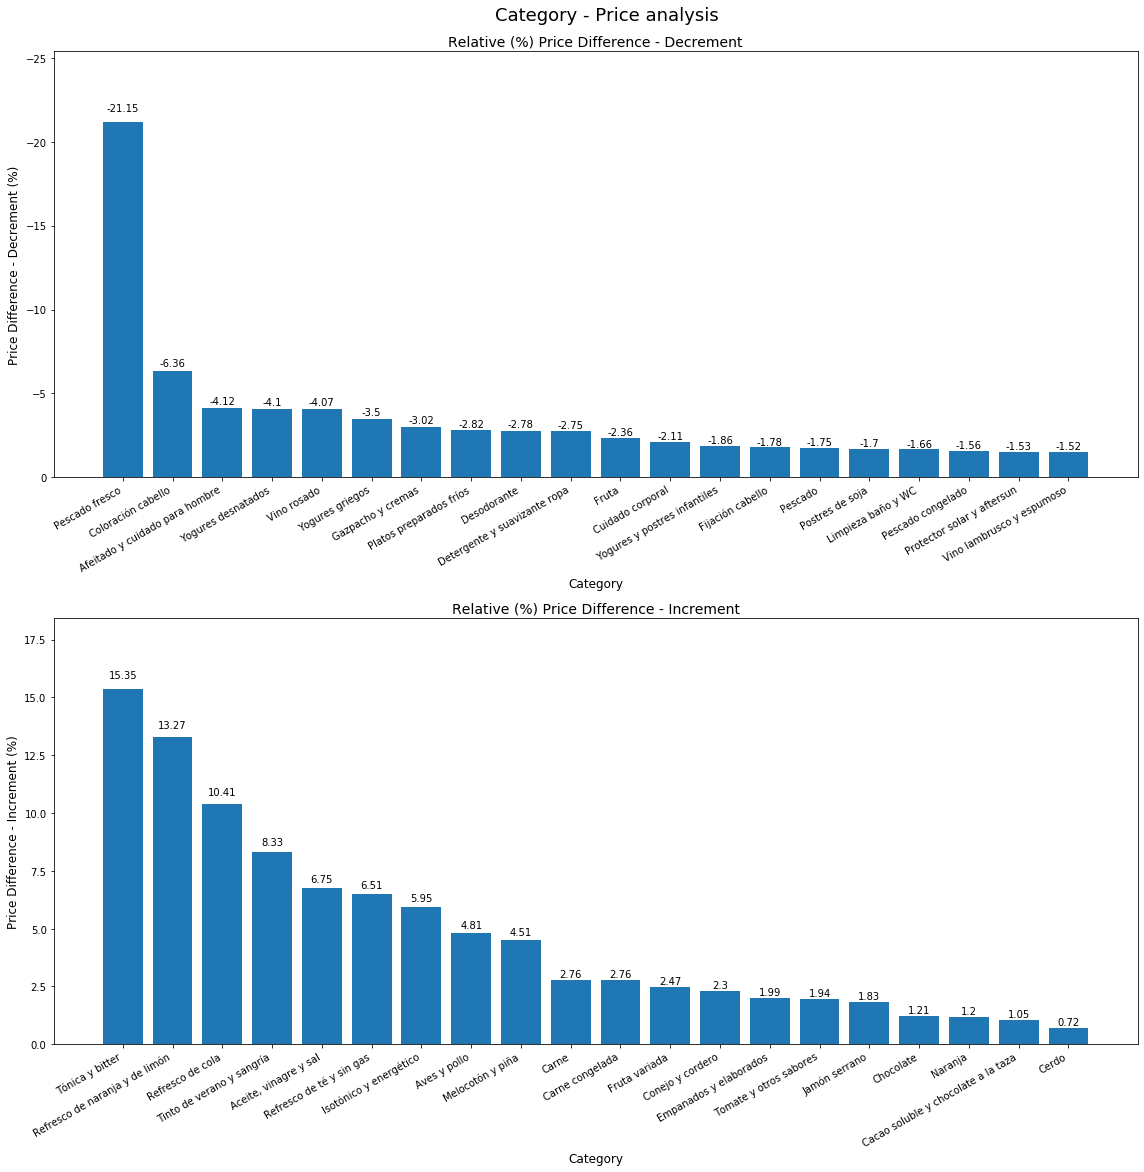

In [59]:
path1 = "../data/Mercadona_2021-01-09.csv"
path2 = "../data/Mercadona_2021-06-01.csv"
fig_path = "../reporting/charts/"

filter_level = None
filter_elements = None
group_level = "category"
difference_type = "relative"
bar_number = 20

drop_zeros = True

df, figure = main(path1, path2, 
            filter_level, filter_elements, 
            group_level, 
            difference_type, bar_number=20, drop_zeros=True, fig_path=fig_path, hacendado=False)

In [16]:
df1, date1 = load_csv("../data/Mercadona_2021-01-09.csv")
df2, date2 = load_csv("../data/Mercadona_2021-06-01.csv")

../data/Mercadona_2021-01-09.csv (6402, 8)
../data/Mercadona_2021-06-01.csv (6481, 8)


In [17]:
min_max_df = min_max_products(df1, df2)

In [47]:
min_max_df.set_index(["Time", "Min/Max"])

Category             Subcategory  \
Time       Min/Max                                              
2021-01-09 Min      Bollería envasada  Polvorones y mazapanes   
           Max          Jamón serrano           Jamón serrano   
2021-06-01 Min           Pan de horno        Pan de bocadillo   
           Max          Jamón serrano           Jamón serrano   

                                                            Product  \
Time       Min/Max                                                    
2021-01-09 Min                         Bolitas de coco Antiu Xixona   
           Max      Jamón de bellota ibérico 100% Campo Extremadura   
2021-06-01 Min                                            Panecillo   
           Max      Jamón de bellota ibérico 100% Campo Extremadura   

                                  Specs   Price  
Time       Min/Max                               
2021-01-09 Min              20 g aprox.    0.06  
           Max      Pieza 9,5 kg aprox.  460.75  
2021-06-01 Min             1 ud. (45 g)    0.10  
           Max      Pieza 9,5 kg aprox.  460.75

### Benford's Law!

In [60]:
df = pd.read_csv("../data/Mercadona_2021-06-01.csv")

In [61]:
df.Price = df.Price.apply(lambda x: x.strip().rstrip(" €").replace(",", "."))

In [62]:
df["FirstDigit"] = df.Price.apply(lambda x: x[:1])

In [63]:
df.FirstDigit = df.FirstDigit.astype("int")

In [64]:
clean = df[df.FirstDigit != 0]

In [65]:
g = clean.groupby("FirstDigit").count()[["Price"]]
g["Percentage"] = g.transform(lambda x: round(100*x/x.sum(),1))

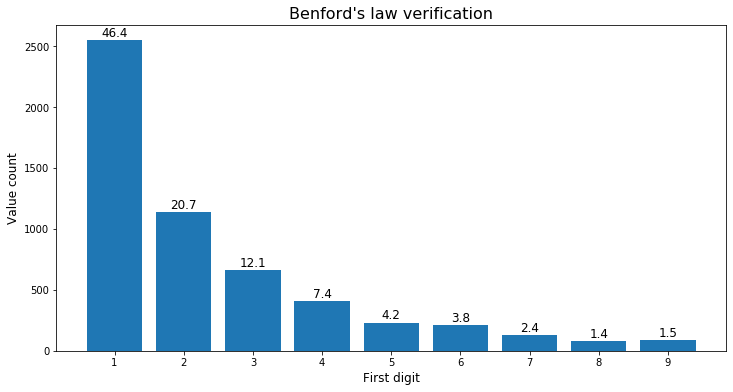

In [66]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=g.index, height=g.Price.values)
ax.set_xticks(g.index)
ax.set_ylabel("Value count", fontdict={"size": 12})
ax.set_xlabel("First digit", fontdict={"size": 12})
ax.set_title("Benford's law verification", fontdict={"size": 16})

rects = ax.patches
labels = list(g.Percentage.values.astype("str"))

for rect, label in zip(rects, labels):
    height = rect.get_height()
    x_pos = rect.get_x() + rect.get_width() / 2
    y_pos = height + 5
    ax.text(x_pos, y_pos, label, ha='center', va='bottom', fontdict={"size":12})
plt.show();